In [3]:
pip install statsmodels 

     |████████████████████████████████| 9.6 MB 877 kB/s eta 0:00:01
     |████████████████████████████████| 233 kB 468 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [27]:
# Packages imports
# Packages imports
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

%matplotlib inline

# Some plot styling preferences
plt.style.use('seaborn-whitegrid')
font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 14}

mpl.rc('font', **font)
effect_size = sms.proportion_effectsize(0.13, 0.15)    # Calculating effect size based on our expected rates

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number                          

print(required_n)

4720


We’d need at least 4720 observations for each group.

### Data wrangling/ data cleaning

In [11]:
df = pd.read_csv('AdSmartABdata.csv')
df.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8077 entries, 0 to 8076
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   auction_id   8077 non-null   object
 1   experiment   8077 non-null   object
 2   date         8077 non-null   object
 3   hour         8077 non-null   int64 
 4   device_make  8077 non-null   object
 5   platform_os  8077 non-null   int64 
 6   browser      8077 non-null   object
 7   yes          8077 non-null   int64 
 8   no           8077 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 568.0+ KB


In [13]:
missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing

,count,%
auction_id,0,0.0
experiment,0,0.0
date,0,0.0
hour,0,0.0
device_make,0,0.0
platform_os,0,0.0
browser,0,0.0
yes,0,0.0
no,0,0.0


No missing values

In [18]:
df.duplicated().any()

False

In [20]:
df.shape

(8077, 9)

There are no dublicates in data

In [25]:
pd.crosstab(df['experiment'], df['browser'])

browser,Android,Chrome,Chrome Mobile,Chrome Mobile WebView,Chrome Mobile iOS,Edge Mobile,Facebook,Firefox Mobile,Mobile Safari,Mobile Safari UI/WKWebView,Opera Mini,Opera Mobile,Pinterest,Puffin,Samsung Internet
experiment,,,,,,,,,,,,,,,
control,1,1,2410,292,34,0,561,0,246,30,1,0,2,1,492
exposed,0,2,2144,1197,17,1,203,1,91,14,0,3,1,0,332


### EDA - exploring the data

Columns Description
auction_id: the unique id of the online user who has been presented the BIO. In standard terminologies this is called an impression id. The user may see the BIO questionnaire but choose not to respond. In that case both the yes and no columns are zero.

experiment: which group the user belongs to - control or exposed.

control: users who have been shown a dummy ad
exposed: users who have been shown a creative, an online interactive ad, with the SmartAd brand.
date: the date in YYYY-MM-DD format

hour: the hour of the day in HH format.

device_make: the name of the type of device the user has e.g. Samsung

platform_os: the id of the OS the user has.

browser: the name of the browser the user uses to see the BIO questionnaire.

yes: 1 if the user chooses the “Yes” radio button for the BIO questionnaire.

no: 1 if the user chooses the “No” radio button for the BIO questionnaire.

#Before we go ahead and sample the data to get our subset, let’s make sure there are no users that have been sampled multiple times.

In [24]:
session_counts = df['auction_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(f'There are {multi_users} auctions that appear multiple times in the dataset')

There are 0 auctions that appear multiple times in the dataset


Now that our DataFrame is nice and clean, we can proceed and sample n=4720 entries for each of the groups. We can use pandas' DataFrame.sample() method to do this, which will perform Simple Random Sampling for us.

In [35]:
control_sample = df[df['experiment'] == 'control'].sample(n=required_n, random_state=22, replace=True)
treatment_sample = df[df['experiment'] == 'exposed'].sample(n=required_n, random_state=22, replace=True)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)
ab_test

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,b839f402-b514-4112-b19e-cf3464660c49,control,2020-07-07,13,Generic Smartphone,6,Chrome Mobile,0,0
1,89de60f7-5212-47d0-9b12-648040f8af80,control,2020-07-03,15,Samsung SM-G935F,6,Chrome Mobile WebView,0,0
2,3559e3de-dcaf-418b-ad9b-05029efe6697,control,2020-07-06,9,Generic Smartphone,6,Chrome Mobile WebView,0,0
3,be668783-5396-4769-bd15-41094abf645b,control,2020-07-03,21,Samsung SM-J610FN,6,Samsung Internet,0,0
4,1572bad2-681e-4d8b-b12f-1ea75986509a,control,2020-07-05,10,Generic Smartphone,6,Chrome Mobile,0,1
...,...,...,...,...,...,...,...,...,...
9435,446610c4-e958-43ea-852a-505afba88367,exposed,2020-07-09,13,Generic Smartphone,6,Chrome Mobile,0,0
9436,1021fd94-e132-4d93-b10a-5b40a77038e6,exposed,2020-07-05,6,F8331,6,Chrome Mobile WebView,0,0
9437,443257bb-640d-41a2-85f7-cd5b9d305b88,exposed,2020-07-08,18,Generic Smartphone,6,Chrome Mobile,0,0
9438,baeb2fc4-295f-416b-a216-1cdab2594e8a,exposed,2020-07-08,18,XiaoMi Redmi Note 8 Pro,6,Chrome Mobile,0,0


In [36]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   auction_id   9440 non-null   object
 1   experiment   9440 non-null   object
 2   date         9440 non-null   object
 3   hour         9440 non-null   int64 
 4   device_make  9440 non-null   object
 5   platform_os  9440 non-null   int64 
 6   browser      9440 non-null   object
 7   yes          9440 non-null   int64 
 8   no           9440 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 663.9+ KB


In [37]:
ab_test['experiment'].value_counts()

control    4720
exposed    4720
Name: experiment, dtype: int64

### Visualising the results

In [40]:
conversion_rates = ab_test.groupby('experiment')['yes']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
experiment,,,
control,0.069,0.253,0.004
exposed,0.068,0.251,0.004


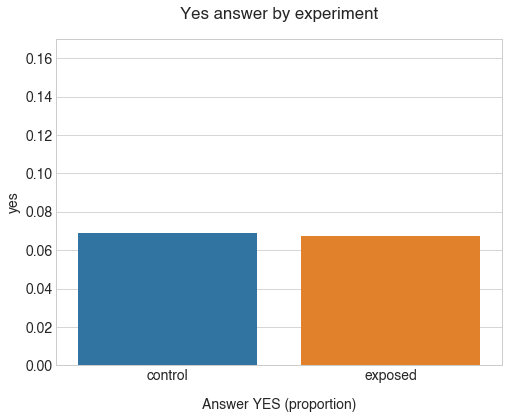

In [42]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['experiment'], y=ab_test['yes'], ci=False)

plt.ylim(0, 0.17)
plt.title('Yes answer by experiment', pad=20)
plt.xlabel('Answer YES (proportion)', labelpad=15);

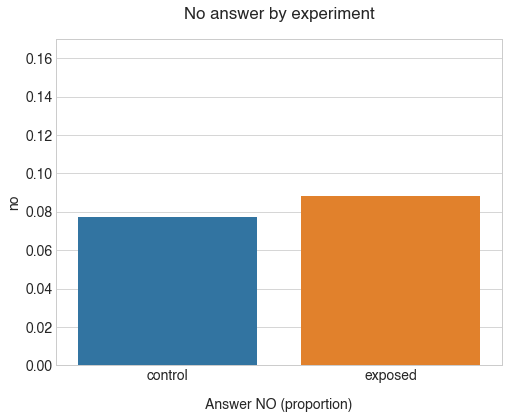

In [43]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['experiment'], y=ab_test['no'], ci=False)

plt.ylim(0, 0.17)
plt.title('No answer by experiment', pad=20)
plt.xlabel('Answer NO (proportion)', labelpad=15);

### Testing the hypothesis

In [44]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
control_results = ab_test[ab_test['experiment'] == 'control']['yes']
treatment_results = ab_test[ab_test['experiment'] == 'exposed']['yes']
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for exposed group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 0.24
p-value: 0.807
ci 95% for control group: [0.062, 0.076]
ci 95% for exposed group: [0.060, 0.075]


### Drawing conclusions

Since our p-value=0.807 is way above our α=0.05 threshold, we cannot reject the Null hypothesis Hₒ, which means that our new design did not perform significantly different than our old one.
